In [1]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras.models import Sequential,load_model
from keras.layers import Embedding,Dense,Flatten
from keras.layers import Bidirectional
from keras_self_attention import SeqSelfAttention
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
#from keras.models import load_model
import numpy as np
import os,sys
import math
input_path = "/home/ubuntu/static_mixed"
word2vec_model = KeyedVectors.load("/home/ubuntu/first.model", mmap='r')


Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tenso

In [2]:
label_dict={}
def create_label():
    
    with open("/home/ubuntu/composite.txt") as file:
        for _ in range(18227):
            line  = file.readline().strip().split(",")
            label_dict[line[0]] = line[1]
create_label()

#print(label_dict)

In [3]:
#HERE START GENERATOR THINGY
import os
import random
#nb_words=len(word2vec_model.wv.vocab), will be parameter for tokenizer
tokenizer = Tokenizer(filters='#\n')
tokenizer.fit_on_texts(word2vec_model.wv.vocab.keys())
word_index = tokenizer.word_index
temp_array=[]
batch_size = 75
def get_content(file_names):
    c=0 
    temp_array=[]
    label_array=[]
    while True:
        if c>=len(file_names):
            c=0
        for i,j in enumerate(file_names[c:c+batch_size]):
            l = open("/home/ubuntu/static_mixed/"+j,'r').read().strip()
 
            padded_sequence =  sequence.pad_sequences(tokenizer.texts_to_sequences([l]),maxlen=4000, padding='post',truncating='post')

            temp_array.append(padded_sequence[0])
            if int(label_dict.get(j))==1:
                label_array.append([0,1])
            else:
                label_array.append([1,0])

        temp_array = np.array(temp_array)
        label_array = np.array(label_array)
        #print("\nYIELDING FROM c = ",c," c+batch_size = ",c+batch_size," and length of temp_array = ",len(temp_array),len(label_array))
        yield (temp_array, label_array)
        label_array=[]
        temp_array=[]
        c+=batch_size
files_ = os.listdir("/home/ubuntu/static_mixed")
random.shuffle(files_)
train_data = get_content(files_)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [4]:
embedding_matrix = np.zeros((len(word2vec_model.wv.vocab)+1,100))
for word, i in word_index.items():
    embedding_matrix[i]=word2vec_model.wv[word]
model = Sequential()
model.add(Embedding(len(word2vec_model.wv.vocab)+1,100,weights=[embedding_matrix],input_length=4000,mask_zero=True))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(SeqWeightedAttention())
model.add(Dense(2,activation='softmax'))
model.layers[0].trainable = False
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4000, 100)         14041000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4000, 256)         234496    
_________________________________________________________________
seq_weighted_attention_1 (Se (None, 256)               257       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 14,276,267
Trainable params: 235,267
Non-trainable params: 14,041,000
_________________________________________________________________


In [5]:
#model=load_model("bi_lstm_model.h5")
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [6]:
steps_per_epoch = math.ceil(len(files_)/batch_size)
model.fit_generator(train_data,epochs=7,steps_per_epoch=steps_per_epoch)

Epoch 1/7
204/204 [==============================] - 2689s 13s/step - loss: 0.1175 - acc: 0.9616
Epoch 2/7
204/204 [==============================] - 2668s 13s/step - loss: 0.0153 - acc: 0.9945
Epoch 3/7
204/204 [==============================] - 2651s 13s/step - loss: 0.0083 - acc: 0.9971
Epoch 4/7
204/204 [==============================] - 2648s 13s/step - loss: 0.0088 - acc: 0.9969
Epoch 5/7
204/204 [==============================] - 2652s 13s/step - loss: 0.0074 - acc: 0.9975
Epoch 6/7
204/204 [==============================] - 2647s 13s/step - loss: 0.0044 - acc: 0.9984
Epoch 7/7
204/204 [==============================] - 2648s 13s/step - loss: 0.0060 - acc: 0.9984


In [7]:
model.save('attn_bi_lstm_model.h5')

In [8]:
#VALidation generator

validation_size = 50
def get_validation_data(file_names):
    c=0 
    temp_array=[]
    
    while True:
        if c>=len(file_names):
            c=0
        for i,j in enumerate(file_names[c:c+validation_size]):
            l = open("/home/ubuntu/static_validation/"+j,'r').read().strip()
            padded_sequence =  sequence.pad_sequences(tokenizer.texts_to_sequences([l]),maxlen=4000,padding='post',truncating='post')
            temp_array.append(padded_sequence[0])
            

        temp_array = np.array(temp_array)
        #label_array = np.array(label_array)
        #temp_array = temp_array[..., np.newaxis]
        #print("\nYIELDING FROM c = ",c," c+validation_size = ",c+validation_size," and length of temp_array = ",len(temp_array))
        yield (temp_array)
        
        temp_array=[]
        c+=validation_size
list_of_validation_files = os.listdir("/home/ubuntu/static_validation")
#print(list_of_validation_files)
validation_generator = get_validation_data(list_of_validation_files)

In [9]:
# print(math.ceil(len(list_of_validation_files)/validation_size))
# raise
prediction = model.predict_generator(validation_generator,math.ceil(len(list_of_validation_files)/validation_size))

In [10]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.clf()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",verticalalignment="top",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion-Matrix-Attn-Bi-Static.png')
    plt.tight_layout()


[0 0 1 ... 1 0 0]
Confusion matrix, without normalization
[[1990   10]
 [   4  996]]


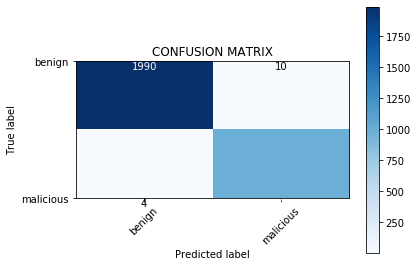

In [11]:
from sklearn.metrics import confusion_matrix
actual_labels=[]
for i,j in enumerate(list_of_validation_files):
    if int(label_dict.get(j))==1:
                actual_labels.append(1)
    else:
                actual_labels.append(0)
#print(actual_labels)
#print(prediction)
prediction1 = np.argmax(prediction, axis=1) 
print(prediction1)

cm = confusion_matrix(actual_labels, prediction1)
plot_confusion_matrix(cm,['benign','malicious'],title='CONFUSION MATRIX')

Area under graph 0.9998456459183243
-------------------------------------------------
Precision for Malicious apps 0.9900596421471173
Recall for Malicious apps 0.996
F1-score for Malicious apps  0.9930209371884346
-------------------------------------------------
Precision for Benign apps 0.9979939819458375
Recall for Benign apps 0.995
F1-score for Benign apps  0.9964947421131698


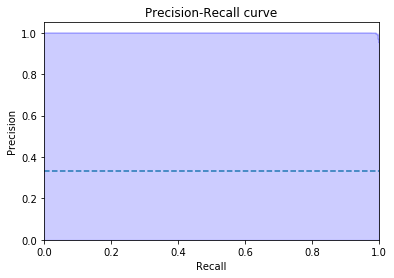

In [12]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from funcsigs import signature
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

def call_precision_recall_curve(truelabel,predictedlabel,actualprediction,label):
    
    #print(truelabel.shape)
    #print(actualprediction.shape)
    
    precision, recall, _ = precision_recall_curve(truelabel,actualprediction)
    au = auc(recall, precision)
    print("Area under graph "+str(au))
    print("-------------------------------------------------")
    rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
    precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
    f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
    print("Precision for Malicious apps "+str(precise_score))
    print("Recall for Malicious apps "+str(rec_score))
    print("F1-score for Malicious apps  " + str(f1))
    print("-------------------------------------------------")
    rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
    precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
    f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
    print("Precision for Benign apps "+str(precise_score))
    print("Recall for Benign apps "+str(rec_score))
    print("F1-score for Benign apps  " + str(f1))
    
    
    #plot the no-skill line too
    positive_cases = sum(truelabel)/len(truelabel)
    plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')
    
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.savefig('Precicion-Recall-Curve-Attn-Bi-Static.png')
prediction_for_1=[]
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])
call_precision_recall_curve(np.array(actual_labels),np.array(prediction1),np.array(prediction_for_1),1)